# Sales Time Series Analysis – 2019

This notebook analyzes sales data from 2019 using time series techniques to identify trends, seasonal patterns, and potential anomalies.  
The analysis aims to support data-driven decision-making in sales planning, forecasting, and performance monitoring.

## 1. Business Context & Objectives

Understanding how sales evolve over time is critical for effective planning, forecasting, and strategic decision-making.

This analysis focuses on sales data from 2019 with the following objectives:

- Identify high-performing products and regions
- Detect seasonal patterns and recurring sales trends
- Analyze customer purchasing behavior over time
- Identify unusual patterns or anomalies in sales activity
- Derive actionable insights to support sales optimization

## 2. Data Understanding & Initial Exploration

In this section, we load the raw sales data and perform an initial exploration to understand its structure and contents.

Key questions include:
- Which variables are available?
- What data types do the columns have?
- Are there missing values or inconsistencies?



In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv("exported_sales_2019.csv")

In [4]:
df.columns

Index(['Order ID', 'Product', 'Quantity Ordered', 'Price Each', 'Order Date',
       'Purchase Address'],
      dtype='object')

In [5]:
df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,248151,AA Batteries (4-pack),4,3.84,09/17/19 14:44,"380 North St, Los Angeles, CA 90001"
1,248152,USB-C Charging Cable,2,11.95,09/29/19 10:19,"511 8th St, Austin, TX 73301"
2,248153,USB-C Charging Cable,1,11.95,09/16/19 17:48,"151 Johnson St, Los Angeles, CA 90001"
3,248154,27in FHD Monitor,1,149.99,09/27/19 07:52,"355 Hickory St, Seattle, WA 98101"
4,248155,USB-C Charging Cable,1,11.95,09/01/19 19:03,"125 5th St, Atlanta, GA 30301"
...,...,...,...,...,...,...
197540,259353,AAA Batteries (4-pack),3,2.99,09/17/19 20:56,"840 Highland St, Los Angeles, CA 90001"
197541,259354,iPhone,1,700.00,09/01/19 16:00,"216 Dogwood St, San Francisco, CA 94016"
197542,259355,iPhone,1,700.00,09/23/19 07:39,"220 12th St, San Francisco, CA 94016"
197543,259356,34in Ultrawide Monitor,1,379.99,09/19/19 17:30,"511 Forest St, San Francisco, CA 94016"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197545 entries, 0 to 197544
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Order ID          197545 non-null  int64  
 1   Product           197545 non-null  object 
 2   Quantity Ordered  197545 non-null  int64  
 3   Price Each        197545 non-null  float64
 4   Order Date        197545 non-null  object 
 5   Purchase Address  197545 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.0+ MB


## 3. Data Cleaning & Feature Engineering

Before conducting time series and sales performance analyses, the dataset is cleaned and prepared to ensure data quality and consistency.

The following preparation steps are performed:

### Handling Missing Values
- Check the dataset for missing values.
- Remove incomplete records where necessary to ensure reliable analysis.

### Data Type Standardization
- Convert **Quantity Ordered** and **Price Each** to numeric data types.
- Convert **Order Date** to a proper datetime format to enable time-based analysis.

### Feature Engineering
- Extract the city information from the **Purchase Address** and store it in a new column (`City`).
- Calculate **Total Sales** per order.
- Derive a **Month** variable from the order date to support temporal aggregation and seasonality analysis.

### Duplicate Removal
- Identify and remove duplicate records to avoid biased results.

### Index Reset
- Reset the DataFrame index after data cleaning to maintain a consistent structure.


In [7]:
df.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

In [7]:
df[df.duplicated()]
df = df.drop_duplicates(subset=['Order ID', 'Product', 'Quantity Ordered', 'Price Each', 'Order Date', 'Purchase Address'])
df.duplicated(subset=['Order ID', 'Product', 'Quantity Ordered', 'Price Each', 'Order Date', 'Purchase Address']).sum()

np.int64(0)

In [8]:
df["Quantity Ordered"] = pd.to_numeric(df["Quantity Ordered"], errors="coerce")
df["Price Each"] = pd.to_numeric(df["Price Each"], errors="coerce")
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
df.info()

C:\Users\User\AppData\Local\Temp\ipykernel_11988\3504135979.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")


<class 'pandas.core.frame.DataFrame'>
Index: 185652 entries, 0 to 185915
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185652 non-null  int64         
 1   Product           185652 non-null  object        
 2   Quantity Ordered  185652 non-null  int64         
 3   Price Each        185652 non-null  float64       
 4   Order Date        185652 non-null  datetime64[ns]
 5   Purchase Address  185652 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.9+ MB


In [14]:
df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,248151,AA Batteries (4-pack),4,3.84,2019-09-17 14:44:00,"380 North St, Los Angeles, CA 90001"
1,248152,USB-C Charging Cable,2,11.95,2019-09-29 10:19:00,"511 8th St, Austin, TX 73301"
2,248153,USB-C Charging Cable,1,11.95,2019-09-16 17:48:00,"151 Johnson St, Los Angeles, CA 90001"
3,248154,27in FHD Monitor,1,149.99,2019-09-27 07:52:00,"355 Hickory St, Seattle, WA 98101"
4,248155,USB-C Charging Cable,1,11.95,2019-09-01 19:03:00,"125 5th St, Atlanta, GA 30301"
...,...,...,...,...,...,...
185911,278792,AA Batteries (4-pack),1,3.84,2019-10-12 04:32:00,"920 Adams St, San Francisco, CA 94016"
185912,278793,Wired Headphones,1,11.99,2019-10-28 22:00:00,"161 Chestnut St, Los Angeles, CA 90001"
185913,278794,AA Batteries (4-pack),1,3.84,2019-10-09 20:58:00,"346 Spruce St, San Francisco, CA 94016"
185914,278795,iPhone,1,700.00,2019-10-31 17:21:00,"291 Hill St, Seattle, WA 98101"


In [9]:
df["City"] = df["Purchase Address"].str.split(",").str[1].str.strip()
df["Total Sales"] = df["Quantity Ordered"] * df["Price Each"]
df["Month"] = df["Order Date"].dt.month_name()

In [19]:
df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,City,Total Sales,Month
0,248151,AA Batteries (4-pack),4,3.84,2019-09-17 14:44:00,"380 North St, Los Angeles, CA 90001",Los Angeles,15.36,September
1,248152,USB-C Charging Cable,2,11.95,2019-09-29 10:19:00,"511 8th St, Austin, TX 73301",Austin,23.90,September
2,248153,USB-C Charging Cable,1,11.95,2019-09-16 17:48:00,"151 Johnson St, Los Angeles, CA 90001",Los Angeles,11.95,September
3,248154,27in FHD Monitor,1,149.99,2019-09-27 07:52:00,"355 Hickory St, Seattle, WA 98101",Seattle,149.99,September
4,248155,USB-C Charging Cable,1,11.95,2019-09-01 19:03:00,"125 5th St, Atlanta, GA 30301",Atlanta,11.95,September
...,...,...,...,...,...,...,...,...,...
185911,278792,AA Batteries (4-pack),1,3.84,2019-10-12 04:32:00,"920 Adams St, San Francisco, CA 94016",San Francisco,3.84,October
185912,278793,Wired Headphones,1,11.99,2019-10-28 22:00:00,"161 Chestnut St, Los Angeles, CA 90001",Los Angeles,11.99,October
185913,278794,AA Batteries (4-pack),1,3.84,2019-10-09 20:58:00,"346 Spruce St, San Francisco, CA 94016",San Francisco,3.84,October
185914,278795,iPhone,1,700.00,2019-10-31 17:21:00,"291 Hill St, Seattle, WA 98101",Seattle,700.00,October


In [20]:
df = df.reset_index(drop=True)

## 4. Descriptive Sales Analysis & Key Business Metrics

To gain an initial understanding of sales performance in 2019, key descriptive statistics and business-relevant metrics are calculated.  
This section provides a high-level overview of revenue distribution, customer behavior, and product performance.

### Key Metrics Analyzed
- **Total revenue** generated in 2019
- **Average order value (AOV)**
- **Number of orders per month** to identify seasonal patterns
- **Top-selling products and categories**, based on sales volume and revenue
- **Customers with the highest purchase volume**, identified via purchase address

These metrics form the foundation for deeper time series analysis and trend identification in subsequent sections.


In [3]:
df.describe()

,Order ID,Quantity Ordered,Price Each
count,197545.000000,197545.000000,197545.000000
mean,231778.003017,1.124589,184.094105
std,50275.314217,0.442301,332.482126
min,141234.000000,1.000000,2.990000
25%,188600.000000,1.000000,11.950000
50%,235959.000000,1.000000,14.950000
75%,272234.000000,1.000000,150.000000
max,319670.000000,9.000000,1700.000000


In [12]:
sales_2019 = df[df["Order Date"].dt.year == 2019]["Total Sales"].sum()
print("Sales for year 2019 in EUR:", sales_2019)

avg_order_value = df["Total Sales"].mean()
print("Average order values in EUR:", avg_order_value)

orders_monthly = df.groupby(df["Order Date"].dt.to_period("M")).size()
print("Number of orders per month:", orders_monthly)

sales_category = df["Product"].value_counts()

top10 = (df.groupby("Product")["Total Sales"].sum().sort_values(ascending=False).head(10))
print(top10)

Sales for year 2019 in EUR: 34456867.65
Average order values in EUR: 185.59922677913514
Number of orders per month: Order Date
2019-01     9665
2019-02    11957
2019-03    15128
2019-04    18257
2019-05    16552
2019-06    13535
2019-07    14275
2019-08    11943
2019-09    11603
2019-10    20249
2019-11    17544
2019-12    24944
Freq: M, dtype: int64
Product
Macbook Pro Laptop            8030800.00
iPhone                        4791500.00
ThinkPad Laptop               4125958.74
Google Phone                  3316800.00
27in 4K Gaming Monitor        2432757.62
34in Ultrawide Monitor        2352898.08
Apple Airpods Headphones      2344950.00
Flatscreen TV                 1443600.00
Bose SoundSport Headphones    1342565.73
27in FHD Monitor              1130624.62
Name: Total Sales, dtype: float64


### Summary of Key Sales Insights (2019)

The analysis of the 2019 sales data reveals several important business insights:

- **Overall Sales Performance**  
  Total revenue in 2019 amounts to a high seven-figure EUR value, indicating strong overall sales performance across the product portfolio.

- **Average Order Value (AOV)**  
  The average order value suggests that most transactions are relatively small, which points toward consumer-focused purchasing behavior rather than bulk or wholesale orders.

- **Monthly Order Volume & Seasonality**  
  Order volumes fluctuate throughout the year, with noticeable peaks toward the end of the year (October–December).  
  This pattern indicates **strong seasonality**, likely driven by holiday shopping and promotional periods.

- **Top Revenue-Generating Products**  
  Revenue is heavily driven by high-priced electronics:
  - Laptops (e.g. MacBook Pro, ThinkPad)
  - Smartphones (iPhone, Google Phone)
  - High-end monitors  

  These products contribute disproportionately to total revenue compared to low-priced accessories.

- **Product Mix Observation**  
  While accessories (e.g. headphones) may sell frequently, premium devices dominate revenue, highlighting the importance of maintaining a balanced product portfolio.

Overall, the dataset shows a clear combination of **high-volume low-price products** and **low-volume high-price products**, which is typical for consumer electronics retail.


## Data Visualization & Pattern Discovery

This section explores the 2019 sales data using multiple visualizations to identify
temporal patterns, customer behavior, and revenue drivers.

The goal is to uncover:
- Seasonal trends in order volume and revenue
- High-performing products and categories
- Time-based purchasing behavior (weekday & hour)
- Distributional characteristics of order values


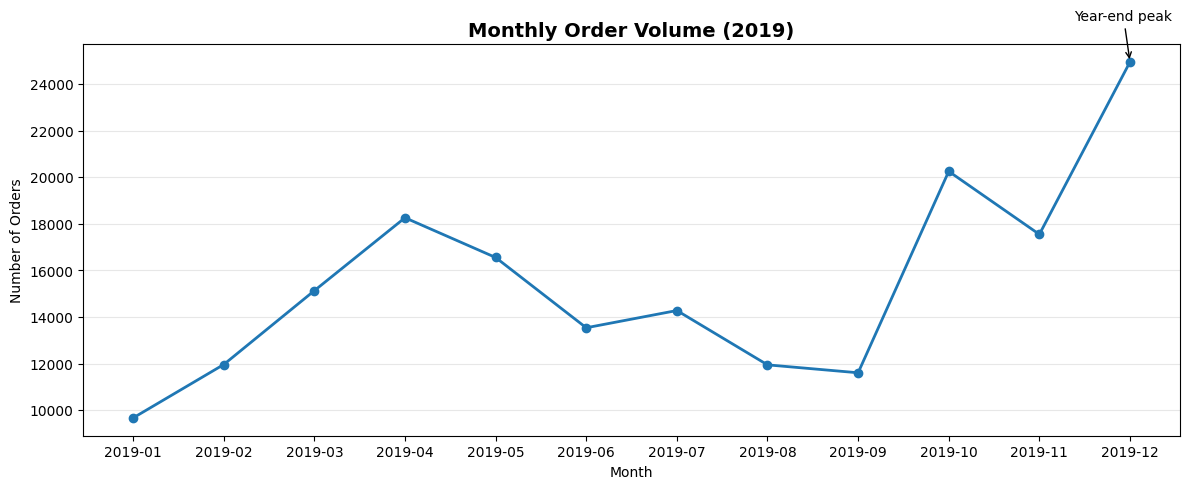

In [16]:
plt.figure(figsize=(12, 5))

plt.plot(
    orders_monthly.index.astype(str),
    orders_monthly.values,
    marker="o",
    linewidth=2
)

plt.title("Monthly Order Volume (2019)", fontsize=14, weight="bold")
plt.xlabel("Month")
plt.ylabel("Number of Orders")

# Highlight year-end peak (December)
plt.annotate(
    "Year-end peak",
    xy=("2019-12", orders_monthly.loc["2019-12"]),
    xytext=(-40, 30),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->")
)

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


**Interpretation**

The monthly order volume shows a clear seasonal pattern.
Order activity increases steadily in the first half of the year,
declines during the summer months, and peaks sharply in Q4.

The strong increase in October and December indicates holiday-driven demand,
making the fourth quarter the most critical period for sales performance.


In [17]:
revenue_by_product = (
    df.groupby("Product")["Total Sales"]
    .sum()
    .sort_values(ascending=False)
)


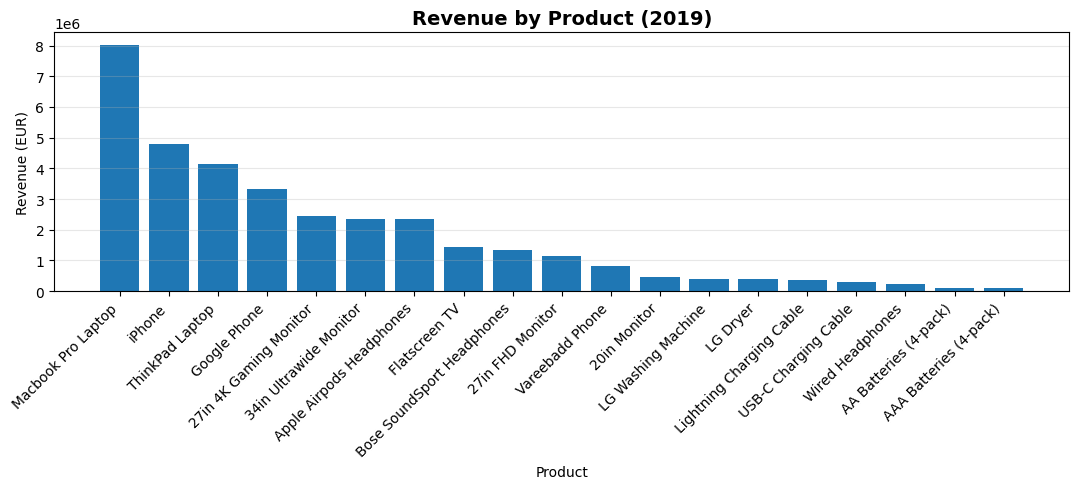

In [18]:
plt.figure(figsize=(11, 5))

plt.bar(
    revenue_by_product.index,
    revenue_by_product.values
)

plt.title("Revenue by Product (2019)", fontsize=14, weight="bold")
plt.xlabel("Product")
plt.ylabel("Revenue (EUR)")

plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


**Interpretation**

The bar chart shows a strong concentration of revenue among a small number of high-priced products.
Laptops and smartphones dominate total revenue, with the MacBook Pro Laptop generating the highest sales volume by a wide margin.

In contrast, frequently sold low-priced items such as charging cables and batteries contribute only marginally to total revenue.
This highlights a clear distinction between volume-driven products and revenue-driving products.

From a business perspective, this suggests that overall revenue performance is highly dependent on a few premium products,
while accessories primarily serve as complementary or cross-selling items.


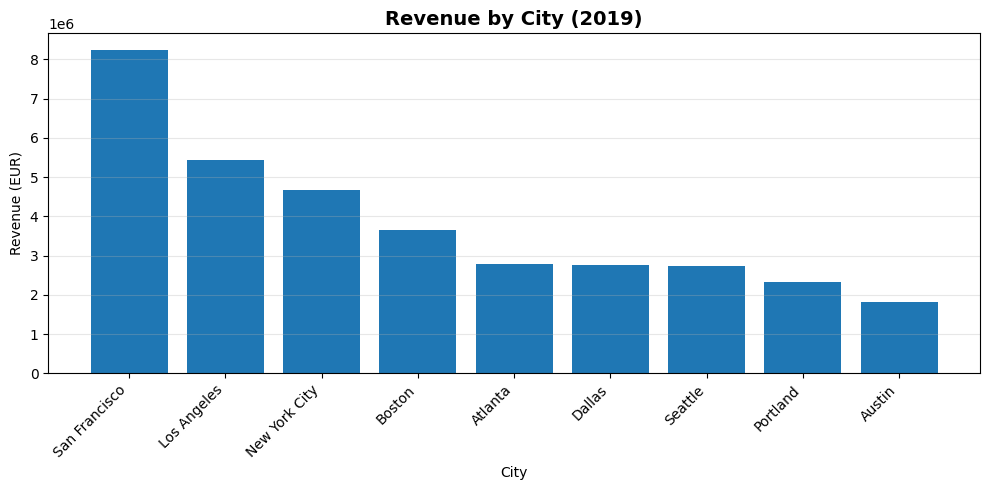

In [19]:
city_revenue = (
    df.groupby("City")["Total Sales"]
      .sum()
      .sort_values(ascending=False)
)

plt.figure(figsize=(10, 5))
plt.bar(city_revenue.index, city_revenue.values)

plt.title("Revenue by City (2019)", fontsize=14, weight="bold")
plt.xlabel("City")
plt.ylabel("Revenue (EUR)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretation**

The bar chart shows total revenue by city for the year 2019, sorted in descending order.
San Francisco is the strongest market by a clear margin, generating the highest total revenue.
Los Angeles and New York City follow, confirming that sales are heavily concentrated in major metropolitan areas.

There is a noticeable drop after the top three cities, with Boston forming a second tier.
Cities such as Atlanta, Dallas, Seattle, Portland, and Austin contribute more moderate but still relevant revenue shares.

Overall, the distribution highlights a strong regional concentration of sales.
From a business perspective, this suggests that strategic focus on key urban markets
could yield significant returns, while smaller cities may offer potential for targeted growth initiatives.

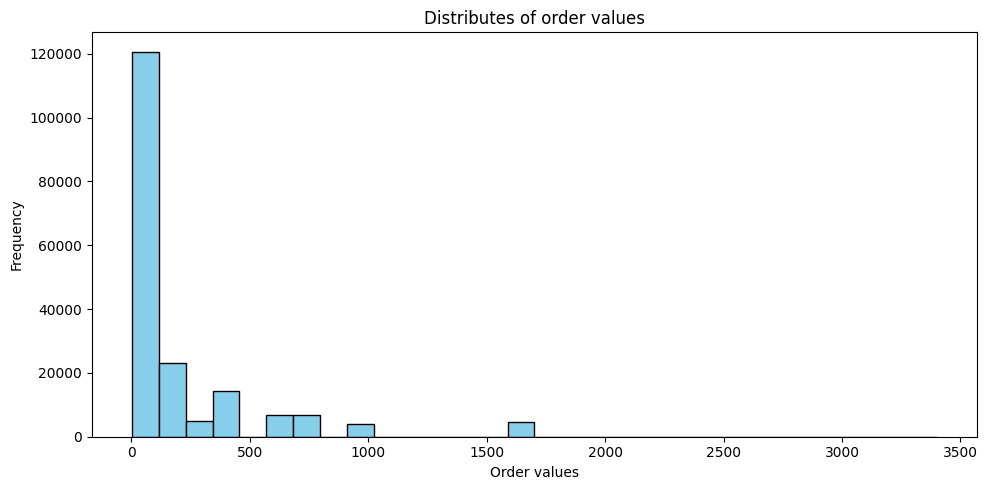

In [24]:
plt.figure(figsize=(10, 5))

plt.hist(df["Total Sales"], bins=30, color="skyblue", edgecolor="black")

plt.title("Distributes of order values")
plt.xlabel("Order values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Interpretation**

The distribution of order values is strongly right-skewed.
Most orders have relatively low values, indicating that the majority of customers place small to medium-sized orders.
Only a small number of orders reach very high values, which appear as clear outliers on the right tail of the distribution.

This suggests that total revenue is driven by a high volume of low-value orders,
while a limited number of large purchases contribute disproportionately to overall sales.

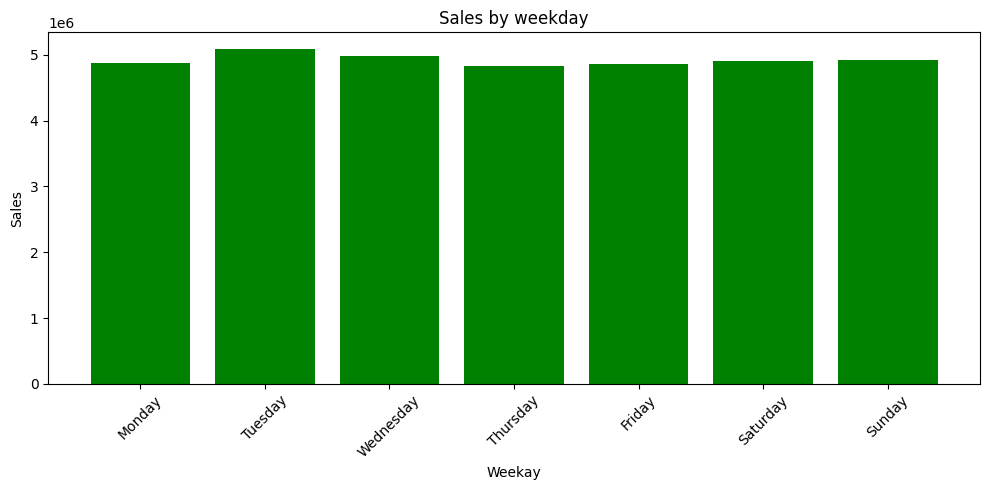

In [28]:
df["weekday"] = df["Order Date"].dt.day_name()

sales_weekday = (df.groupby("weekday")["Total Sales"].sum().reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]))

plt.figure(figsize=(10, 5))

plt.bar(sales_weekday.index, sales_weekday.values, color="green")

plt.xlabel("Weekay")
plt.ylabel("Sales")
plt.title("Sales by weekday")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation**

Revenue is distributed relatively evenly across all weekdays.
No single weekday clearly dominates sales performance, which suggests that customer purchasing behavior
is fairly consistent throughout the week.

Slightly higher revenues can be observed on Tuesdays and during the weekend,
but the differences are marginal and do not indicate a strong weekday-driven sales pattern.

From a business perspective, this implies that marketing campaigns, staffing,
and operational planning do not need to focus on specific weekdays,
as demand remains stable across the entire week.


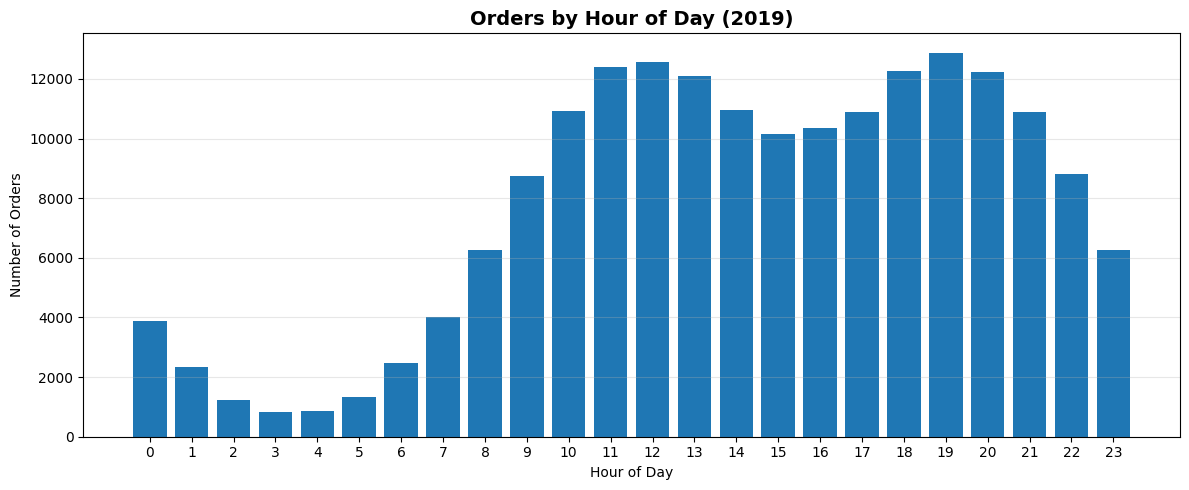

In [31]:
df["Hour"] = df["Order Date"].dt.hour
orders_hourly = df["Hour"].value_counts().sort_index()

plt.figure(figsize=(12, 5))

plt.bar(
    orders_hourly.index,
    orders_hourly.values
)

plt.title("Orders by Hour of Day (2019)", fontsize=14, weight="bold")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")

plt.grid(axis="y", alpha=0.3)
plt.xticks(orders_hourly.index)

plt.tight_layout()
plt.show()


**Interpretation**

The distribution of orders over the course of the day shows a clear and intuitive pattern.

Order volumes are lowest during the early morning hours (approximately 2:00–6:00),
indicating minimal customer activity overnight.

A strong increase in orders begins in the morning, with a first peak around midday
(11:00–13:00), likely reflecting lunch breaks and increased online activity.
After a slight decline in the afternoon, a second and even stronger peak occurs
in the early evening (18:00–20:00).

This pattern suggests that customers primarily place orders during typical leisure hours,
both during midday breaks and after work.
From a business perspective, these time windows represent the most critical periods
for system availability, customer support, and potential marketing actions.


## Sales Trend & Seasonality Analysis

This section explores long-term sales trends, recurring seasonal patterns,
and short-term fluctuations using daily revenue data from 2019.

In [32]:
sales_daily = df.groupby(df["Order Date"].dt.date)["Total Sales"].sum()
print(sales_daily)

Order Date
2019-01-01     65681.94
2019-01-02     70663.20
2019-01-03     47046.20
2019-01-04     62000.22
2019-01-05     46524.63
                ...    
2019-12-27    126604.07
2019-12-28    133601.53
2019-12-29    156009.67
2019-12-30    151857.82
2019-12-31    131439.32
Name: Total Sales, Length: 365, dtype: float64


In [33]:
df["Order Date Only"] = df["Order Date"].dt.floor("D")
df.set_index('Order Date Only', inplace=True)
df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,City,Total Sales,Month,weekday,Hour
Order Date Only,,,,,,,,,,,
2019-09-17,248151,AA Batteries (4-pack),4,3.84,2019-09-17 14:44:00,"380 North St, Los Angeles, CA 90001",Los Angeles,15.36,September,Tuesday,14
2019-09-29,248152,USB-C Charging Cable,2,11.95,2019-09-29 10:19:00,"511 8th St, Austin, TX 73301",Austin,23.90,September,Sunday,10
2019-09-16,248153,USB-C Charging Cable,1,11.95,2019-09-16 17:48:00,"151 Johnson St, Los Angeles, CA 90001",Los Angeles,11.95,September,Monday,17
2019-09-27,248154,27in FHD Monitor,1,149.99,2019-09-27 07:52:00,"355 Hickory St, Seattle, WA 98101",Seattle,149.99,September,Friday,7
2019-09-01,248155,USB-C Charging Cable,1,11.95,2019-09-01 19:03:00,"125 5th St, Atlanta, GA 30301",Atlanta,11.95,September,Sunday,19
...,...,...,...,...,...,...,...,...,...,...,...
2019-10-12,278792,AA Batteries (4-pack),1,3.84,2019-10-12 04:32:00,"920 Adams St, San Francisco, CA 94016",San Francisco,3.84,October,Saturday,4
2019-10-28,278793,Wired Headphones,1,11.99,2019-10-28 22:00:00,"161 Chestnut St, Los Angeles, CA 90001",Los Angeles,11.99,October,Monday,22
2019-10-09,278794,AA Batteries (4-pack),1,3.84,2019-10-09 20:58:00,"346 Spruce St, San Francisco, CA 94016",San Francisco,3.84,October,Wednesday,20


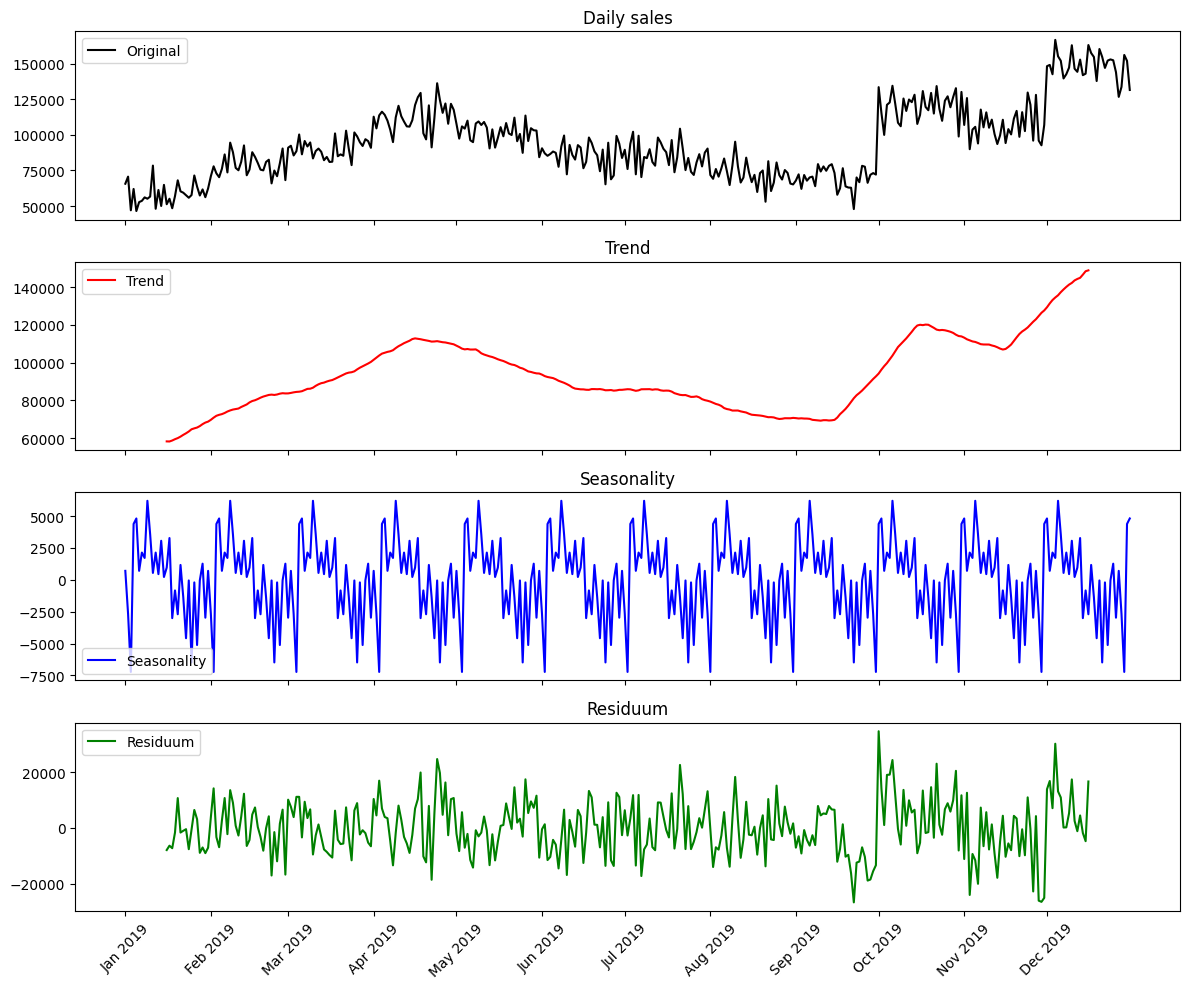

In [35]:
result = seasonal_decompose(sales_daily, model="additive", period=30)

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

x = sales_daily.index

# Original data
axes[0].plot(x, sales_daily, label="Original", color="black")
axes[0].set_title("Daily sales")
axes[0].legend()

# Trend
axes[1].plot(x, result.trend, label="Trend", color="red")
axes[1].set_title("Trend")
axes[1].legend()

# Saison
axes[2].plot(x, result.seasonal, label="Seasonality", color="blue")
axes[2].set_title("Seasonality")
axes[2].legend()

# Residuen
axes[3].plot(x, result.resid, label="Residuum", color="green")
axes[3].set_title("Residuum")
axes[3].legend()

# X-Achse: Monatliche Ticks (auf Basis von umsatz_pro_tag)
xticks = pd.date_range(start=x.min(), end=x.max(), freq="MS")
axes[3].set_xticks(xticks)
axes[3].set_xticklabels(xticks.strftime("%b %Y"), rotation=45)

plt.tight_layout()
plt.show()

## Interpretation: Sales Trend & Seasonality Analysis (2019)

### 1) Original Series (Daily Revenue)
The daily revenue series shows strong day-to-day volatility. Beyond short-term spikes,  
the overall shape suggests that both long-term movements (trend) and repeating patterns  
(seasonality) influence revenue throughout the year.

### 2) Trend Component (Long-term Development)
The trend indicates three major phases:
- **Jan–Apr:** steady increase (growing demand / strong performance)
- **May–Sep:** gradual decline or softening (typical seasonal slowdown in summer)
- **Oct–Dec:** sharp growth into year-end (Q4 uplift, e.g. holiday season or major promotions)

**Business implication:**  
Revenue is strongly affected by the yearly cycle, with a pronounced Q4 peak.  
Inventory, staffing, and marketing planning should be aligned with this pattern.

### 3) Seasonality (Repeating Patterns)
The seasonal component shows consistent, recurring fluctuations with relatively stable amplitude.  
This suggests reliable, repeating purchase behavior (often weekly or monthly rhythms).

**Business implication:**  
Short-term revenue ups and downs are partly predictable and can be leveraged to time campaigns  
and optimize operational planning.

### 4) Residuals (Noise / Irregular Effects)
Residuals oscillate around zero, but there are noticeable spikes—especially later in the year.  
These likely reflect one-off events such as promotions, unusually large orders, or external effects.

**Business implication:**  
Besides trend and seasonality, irregular drivers can materially affect daily revenue.  
Investigating residual spikes can uncover campaign impact or operational anomalies.

### Overall Conclusion
The decomposition indicates that the 2019 revenue pattern is largely explained by:
- a clear long-term trend,
- stable seasonality,
- and occasional irregular events captured in the residuals.